A notebook to test the ABM of tumoral growth. We can manually define a fitness landscape or use OncoSimulR to generate a random one for us.

In [64]:
#We import the common functions and model.
include("./functions.jl")

get_scenario (generic function with 1 method)

In [68]:
#Number of genes of each cell. We need to define it earlier in order to collect the data. Can go up to 10000 easily AS LONG as we dont measure in every timestep.
ngenes=3 

#
# Ejemplo AND con 3 genes:
#
#  WT             000:WT  ->1
#  /\             001:C   ->0
# A  B            010:B   ->1.2
#  \/ (and)       011:BC  ->0
#   C             100:A   ->1.3
#                 101:AC  ->0
#                 110:AB  ->1.5
#                 111:ABC ->2
#
#
fitness=Dict(0=>1, #Fitness of each of the genotypes, the key is the binary representation of the genotype in decimal form.
            1=>0, #Fitness is expressed as a multiplicative effect on pr, but this can be changed.
            2=>1.2,
            3=>0,
            4=>1.3,
            5=>0,
            6=>1.5,
            7=>2)


#OncoSimulR integration! We can use the rfitness function to generate random fitness landscapes
#fitness=OncoSimulR_rfitness(g=ngenes,c=0.5,sd=1) 

#If a genotype fitness is not specified, it can have a default value (0 for not viable or 1 for same effect as WT)
fitness=DefaultDict(1,fitness) 

#We load a scenario from an image
h,w,cell_pos,wall_pos = get_scenario("./scenarios/example2.bmp") #I have added some examples (1 to 4) and some templates.

#We initialize the model.
model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    h=h, #Height of the grid
                    w=w, #Witdh of the grid
                    cell_pos=cell_pos, #The initial positions of the cells
                    wall_pos=wall_pos, #Places the cells can not go
                    ngenes=ngenes, #The number of genes of each cell
                    fitness=fitness, #The fitness of each genotype
                    seed=3) #Seed to get reproducible results

println(model)

#we collect the number of cells of each genotype that are alive
to_collect = [(:genotype, f) for f in genotype_fraction_function_generator(ngenes)]

#we run the simulation
steps= 1000
data, _ = run!(model, agent_step!, steps; adata = to_collect)

#we rename the columns to get a clean "data" DataFrame.
genotypes = [string(reverse(digits(i, base=2, pad=ngenes))) for i in 0:((2^ngenes)-1)]
pushfirst!(genotypes,"step")
rename!(data,genotypes)

AgentBasedModel with 16 agents of type Cell
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: dr, ngenes, fitness, wall_pos, pr, mr, wall_matrix


Row,step,"[0, 0, 0]","[0, 0, 1]","[0, 1, 0]","[0, 1, 1]","[1, 0, 0]","[1, 0, 1]","[1, 1, 0]","[1, 1, 1]"
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,16,0,0,0,0,0,0,0
2,1,17,0,0,0,0,0,0,0
3,2,18,0,0,0,0,0,0,0
4,3,19,0,0,0,0,0,0,0
5,4,18,0,0,0,0,0,0,0
6,5,17,0,0,0,0,0,0,0
7,6,17,0,0,0,0,0,0,0
8,7,18,0,0,0,0,0,0,0
9,8,17,0,0,0,0,0,0,0


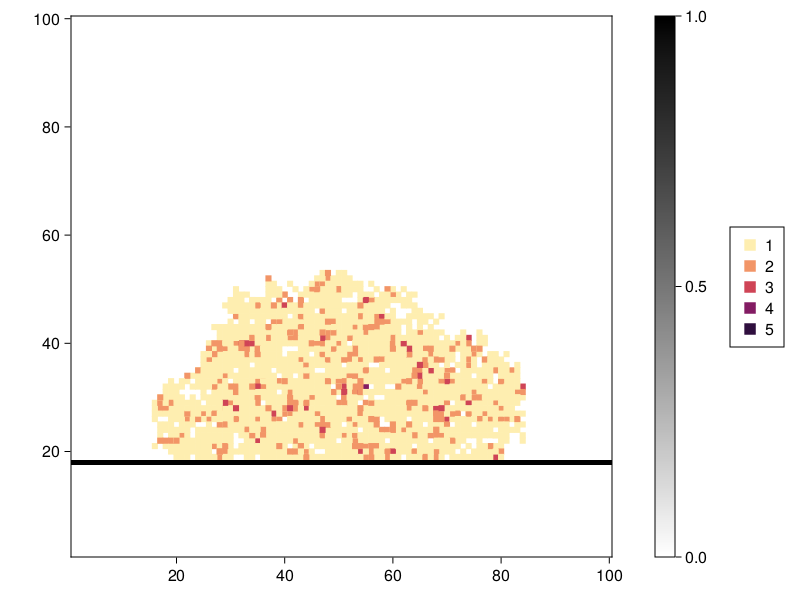

In [69]:
#We plot the "density" of each space in the grid: The number of cells there are in that space.

#Functions to get a color gradient of density
densitycolor(a) = get(colorschemes[:matter], a.near_cells, (1,5))
densitycolor_legend(a) = get(colorschemes[:matter], a, (1,5))

#Right now we plot the walls as a heatarray because its te easiest thing i found to just get it working.
heatarray = :wall_matrix
heatkwargs = (colorrange = (0, 1), colormap = :grayC)

#We plot the density
figure,ax = abmplot(model;ac = densitycolor,as=8,am='■',heatarray,heatkwargs)

#We add a legend
Legend(figure[1, 2],
    [MarkerElement(color = densitycolor_legend(a), marker = '■', markersize = 15, strokecolor = :black) for a in 1:5],
    [string(x) for x in 1:5],
    patchsize = (20, 20), rowgap = 1)

#We display the figure
figure

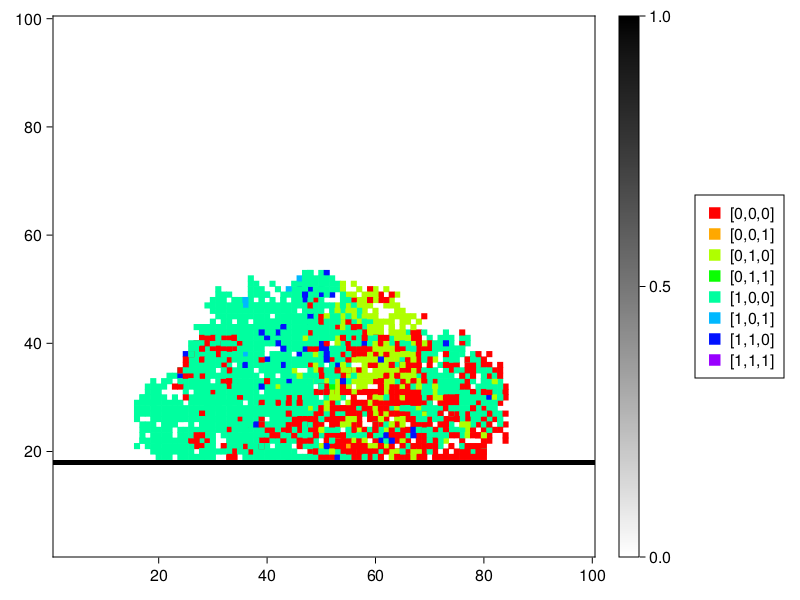

In [74]:
#We plot the genotype of each cell with a different color.

#Functions to get a different color for each genotype
genotypecolor(a) = get(colorschemes[:hsv], bit_2_int(a.genotype), (0,(2^ngenes)+1))
genotypecolor_legend(a) = get(colorschemes[:hsv], a, (0,(2^ngenes)+1))

#We make a static plot
figure, _ = abmplot(model;ac = genotypecolor,as=8,am='■',heatarray,heatkwargs)

#We create a legend for the genotypes
genotypes = [filter(x -> !isspace(x), string(reverse(digits(i, base=2, pad=ngenes)))) for i in 0:((2^ngenes)-1)]
Legend(figure[1, 2],
    [MarkerElement(color = genotypecolor_legend(a), marker = '■', markersize = 15, strokecolor = :black) for a in 0:(2^ngenes)-1],
    genotypes,
    patchsize = (20, 20), rowgap = 1)


#We display the figure
figure

In [37]:
#We can make a video of the simulations!

model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    h=h, #Height of the grid
                    w=w, #Witdh of the grid
                    cell_pos=cell_pos, #The initial positions of the cells
                    wall_pos=wall_pos, #Places the cells can not go
                    ngenes=ngenes, #The number of genes of each cell
                    fitness=fitness, #The fitness of each genotype
                    seed=3) #Seed to get reproducible results

abmvideo(
    "animations/long_AND_3GENES.mp4", model, agent_step!;
    framerate = 20, frames = 1000,ac = genotypecolor,as=8,am='■',heatarray,heatkwargs
    title = "Tumor growth"
)

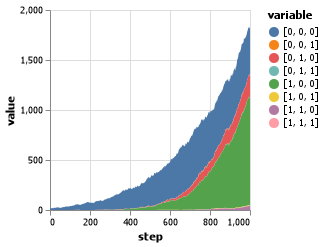

In [72]:
#And lastly we can make plots of both the total number of cells of each genotype
genotypes = [string(reverse(digits(i, base=2, pad=ngenes))) for i in 0:((2^ngenes)-1)]
stacked = stack(data,genotypes)

stacked |>
@vlplot(:area, x=:step, y={:value, stack=:zero}, color="variable:n")

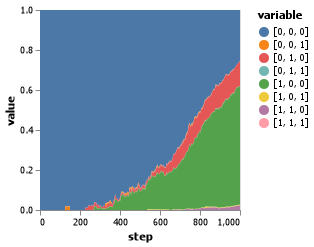

In [73]:
#And the relative number of cells of each genotype
stacked |>
@vlplot(:area, x=:step, y={:value, stack=:normalize}, color="variable:n")